# Análise Comparativa de dados

O objetivo desta etapa é comparar modelos para encontrar o mais adequado para o problema de predição de inadimplência em cartões de crédito. Antes de prosseguir com a análise comparativa, foram realizadas a preparação e o pré-processamento dos dados.

## 1. Preparação dos Dados

### 1.1 **Configurações Iniciais:**

1. **Configurações Iniciais:**
    - Importar bibliotecas e configurar ambiente.
    - Suprimir mensagens de aviso e filtrar mensagens de advertência.
    - Importar módulos necessários, como Path, Markdown, joblib, pandas, numpy, etc.

In [165]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

from pathlib import Path
from IPython.display import Markdown
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns





In [166]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import cross_val_predict







### 1.2 **Carregando Dados:**

2. **Carregando Dados:**
    - Definir o caminho para o arquivo CSV contendo os dados brutos.
    - Utilizar a biblioteca pandas para ler o arquivo CSV em um DataFrame.
    - Mapear valores categóricos para representações mais legíveis.
    - Renomear as colunas conforme necessário.

In [167]:
# Caminho para o arquivo CSV
file_path = '../data/raw/default_of_credit_card_clients-Data.csv'

# Carregar o arquivo CSV em um DataFrame do pandas
df = pd.read_csv(file_path)


# Exibir as primeiras linhas do DataFrame para verificar se a importação foi bem-sucedida
df.head()

,Unnamed: 0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,Y
0,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
1,1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
2,2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0


In [168]:
categories = ['ID','Limit_Bal','Sex','Education','Marriage','Age','Pay_0','Pay_2','Pay_3','Pay_4',
              'Pay_5', 'Pay_6', 'Bill_Amt1', 'Bill_Amt2', 'Bill_Amt3', 'Bill_Amt4', 'Bill_Amt5', 'Bill_Amt6',
              'Pay_Amt1','Pay_Amt2','Pay_Amt3','Pay_Amt4','Pay_Amt5','Pay_Amt6','default payment next month']

In [169]:
#Excluindo os indices xi da tabela para ficar melhor apresentável

df = pd.read_csv(file_path, header=None, names = categories)

df = df.iloc[2:,]
df.reset_index(drop=True, inplace=True) # Redefinindo os índices

pd.set_option('display.max_columns', None)
df.head()

,ID,Limit_Bal,Sex,Education,Marriage,Age,Pay_0,Pay_2,Pay_3,Pay_4,Pay_5,Pay_6,Bill_Amt1,Bill_Amt2,Bill_Amt3,Bill_Amt4,Bill_Amt5,Bill_Amt6,Pay_Amt1,Pay_Amt2,Pay_Amt3,Pay_Amt4,Pay_Amt5,Pay_Amt6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


### 1.3 **Renomear Colunas e Transformações Adicionais**

3. **Renomear Colunas e Transformações Adicionais:**
    - Mapear colunas específicas para nomes mais descritivos.
    - Realizar transformações nos dados, como mapear códigos para categorias compreensíveis.
    - Exibir as primeiras linhas do DataFrame para verificar a transformação bem-sucedida.

In [170]:
sex_mapping = {1: "masculino", 2: "feminino"}
education_mapping = {1: "pós-graduação", 2: "universidade", 3: "ensino médio", 4: "outros"}
marriage_mapping = {1: "casado", 2: "solteiro", 3: "outros"}
pay_mapping = {-2: 'Fatura total paga', -1: 'Pagamento total em dia', 0: 'Pagamento parcial', 1: 'Atrasado em 1 mês', 2: 'Atrasado em 2 mês',  3: 'Atrasado em 3 mês', 4: 'Atrasado em 4 mês', 5: 'Atrasado em 5 mês', 6: 'Atrasado em 6 mês', 7: 'Atrasado em 7 mês', 8: 'Atrasado em 8 mês', 9: 'Atrasado em 9 meses ou mais'}
default_payment_mapping = {0: "não", 1: "sim"}

df["Sex"] = pd.to_numeric(df["Sex"])
df["Education"] = pd.to_numeric(df["Education"])
df["Marriage"] = pd.to_numeric(df["Marriage"])
df["Pay_0"] = pd.to_numeric(df["Pay_0"])
df["Pay_2"] = pd.to_numeric(df["Pay_2"])
df["Pay_3"] = pd.to_numeric(df["Pay_3"])
df["Pay_4"] = pd.to_numeric(df["Pay_4"])
df["Pay_5"] = pd.to_numeric(df["Pay_5"])
df["Pay_6"] = pd.to_numeric(df["Pay_6"])
df["default payment next month"] = pd.to_numeric(df["default payment next month"])

df["Sex"] = df["Sex"].map(sex_mapping)
df["Education"] = df["Education"].map(education_mapping)
df["Marriage"] = df["Marriage"].map(marriage_mapping)
df["Pay_0"] = df["Pay_0"].map(pay_mapping)
df["Pay_2"] = df["Pay_2"].map(pay_mapping)
df["Pay_3"] = df["Pay_3"].map(pay_mapping)
df["Pay_4"] = df["Pay_4"].map(pay_mapping)
df["Pay_5"] = df["Pay_5"].map(pay_mapping)
df["Pay_6"] = df["Pay_6"].map(pay_mapping)
df["default payment next month"] = df["default payment next month"].map(default_payment_mapping)

df.head()

,ID,Limit_Bal,Sex,Education,Marriage,Age,Pay_0,Pay_2,Pay_3,Pay_4,Pay_5,Pay_6,Bill_Amt1,Bill_Amt2,Bill_Amt3,Bill_Amt4,Bill_Amt5,Bill_Amt6,Pay_Amt1,Pay_Amt2,Pay_Amt3,Pay_Amt4,Pay_Amt5,Pay_Amt6,default payment next month
0,1,20000,feminino,universidade,casado,24,Atrasado em 2 mês,Atrasado em 2 mês,Pagamento total em dia,Pagamento total em dia,Fatura total paga,Fatura total paga,3913,3102,689,0,0,0,0,689,0,0,0,0,sim
1,2,120000,feminino,universidade,solteiro,26,Pagamento total em dia,Atrasado em 2 mês,Pagamento parcial,Pagamento parcial,Pagamento parcial,Atrasado em 2 mês,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,sim
2,3,90000,feminino,universidade,solteiro,34,Pagamento parcial,Pagamento parcial,Pagamento parcial,Pagamento parcial,Pagamento parcial,Pagamento parcial,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,não
3,4,50000,feminino,universidade,casado,37,Pagamento parcial,Pagamento parcial,Pagamento parcial,Pagamento parcial,Pagamento parcial,Pagamento parcial,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,não
4,5,50000,masculino,universidade,casado,57,Pagamento total em dia,Pagamento parcial,Pagamento total em dia,Pagamento parcial,Pagamento parcial,Pagamento parcial,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,não


In [171]:
novo_nome_colunas = {
    'ID': 'ID',
    'Limit_Bal': 'Limite_Bancário',
    'Sex': 'Gênero',
    'Education': 'Nível_Educacional',
    'Marriage': 'Estado_Civil',
    'Age': 'Idade',
    'Pay_0': 'Status_Setembro',
    'Pay_2': 'Status_Agosto',
    'Pay_3': 'Status_Julho',
    'Pay_4': 'Status_Junho',
    'Pay_5': 'Status_Maio',
    'Pay_6': 'Status_Abril',
    'Bill_Amt1': 'Saldo_Setembro',
    'Bill_Amt2': 'Saldo_Agosto',
    'Bill_Amt3': 'Saldo_Julho',
    'Bill_Amt4': 'Saldo_Junho',
    'Bill_Amt5': 'Saldo_Maio',
    'Bill_Amt6': 'Saldo_Abril',
    'Pay_Amt1': 'Pagamento_Abril',
    'Pay_Amt2': 'Pagamento_Maio',
    'Pay_Amt3': 'Pagamento_Junho',
    'Pay_Amt4': 'Pagamento_Julho',
    'Pay_Amt5': 'Pagamento_Agosto',
    'Pay_Amt6': 'Pagamento_Setembro',
    'default payment next month': 'Inadimplência_Próximo_Mês'
}

df.rename(columns=novo_nome_colunas, inplace=True)

df.head()

,ID,Limite_Bancário,Gênero,Nível_Educacional,Estado_Civil,Idade,Status_Setembro,Status_Agosto,Status_Julho,Status_Junho,Status_Maio,Status_Abril,Saldo_Setembro,Saldo_Agosto,Saldo_Julho,Saldo_Junho,Saldo_Maio,Saldo_Abril,Pagamento_Abril,Pagamento_Maio,Pagamento_Junho,Pagamento_Julho,Pagamento_Agosto,Pagamento_Setembro,Inadimplência_Próximo_Mês
0,1,20000,feminino,universidade,casado,24,Atrasado em 2 mês,Atrasado em 2 mês,Pagamento total em dia,Pagamento total em dia,Fatura total paga,Fatura total paga,3913,3102,689,0,0,0,0,689,0,0,0,0,sim
1,2,120000,feminino,universidade,solteiro,26,Pagamento total em dia,Atrasado em 2 mês,Pagamento parcial,Pagamento parcial,Pagamento parcial,Atrasado em 2 mês,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,sim
2,3,90000,feminino,universidade,solteiro,34,Pagamento parcial,Pagamento parcial,Pagamento parcial,Pagamento parcial,Pagamento parcial,Pagamento parcial,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,não
3,4,50000,feminino,universidade,casado,37,Pagamento parcial,Pagamento parcial,Pagamento parcial,Pagamento parcial,Pagamento parcial,Pagamento parcial,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,não
4,5,50000,masculino,universidade,casado,57,Pagamento total em dia,Pagamento parcial,Pagamento total em dia,Pagamento parcial,Pagamento parcial,Pagamento parcial,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,não


### 1.4 **Tratamento de Dados para Modelagem**

4. **Tratar Dados para Modelagem:**
    - Nesta etapa, realizamos o tratamento adequado dos dados visando prepará-los para a modelagem. O conjunto de dados específico utilizado é proveniente do arquivo `default_of_credit_card_clients-Data.csv`.

In [172]:
# Definindo colunas numéricas e categóricas
numeric_columns = ['Limite_Bancário', 'Idade', 'Saldo_Setembro', 'Saldo_Agosto', 'Saldo_Julho',
                    'Saldo_Junho', 'Saldo_Maio', 'Saldo_Abril', 'Pagamento_Abril', 'Pagamento_Maio',
                    'Pagamento_Junho', 'Pagamento_Julho', 'Pagamento_Agosto', 'Pagamento_Setembro']

categorical_columns = ['Gênero', 'Nível_Educacional', 'Estado_Civil',
                        'Status_Setembro', 'Status_Agosto', 'Status_Julho', 'Status_Junho', 'Status_Maio', 'Status_Abril',
                        'Inadimplência_Próximo_Mês']

In [173]:
# Criando pipelines para tratar diferentes tipos de variáveis
numeric_preprocessor = Pipeline([
    ('missing', SimpleImputer(strategy='mean')),  # Tratamento de dados faltantes
    ('scaling', StandardScaler())  # Normalização
])

categorical_preprocessor = Pipeline([
    ('missing', SimpleImputer(strategy='most_frequent')),  # Tratamento de dados faltantes
    ('onehot', OneHotEncoder(drop='first'))  # Codificação one-hot para evitar multicolinearidade
])


In [174]:
# Criando um transformer para aplicar os pré-processadores nas variáveis corretas
preprocessing = ColumnTransformer([
    ("numeric", numeric_preprocessor, numeric_columns),
    ("categorical", categorical_preprocessor, categorical_columns)
])

# Aplicando transformações nos dados
df_processed = preprocessing.fit_transform(df)

# Obtendo os nomes das colunas após o processamento
processed_columns = (
    numeric_columns +
    list(preprocessing.named_transformers_['categorical']['onehot'].get_feature_names_out(categorical_columns))
)

# Convertendo a matriz esparsa para DataFrame
df_processed_df = pd.DataFrame(df_processed.toarray(), columns=processed_columns)

# Exibindo as primeiras linhas do DataFrame processado
df_processed_df.head()

,Limite_Bancário,Idade,Saldo_Setembro,Saldo_Agosto,Saldo_Julho,Saldo_Junho,Saldo_Maio,Saldo_Abril,Pagamento_Abril,Pagamento_Maio,Pagamento_Junho,Pagamento_Julho,Pagamento_Agosto,Pagamento_Setembro,Gênero_masculino,Nível_Educacional_outros,Nível_Educacional_pós-graduação,Nível_Educacional_universidade,Estado_Civil_outros,Estado_Civil_solteiro,Status_Setembro_Atrasado em 2 mês,Status_Setembro_Atrasado em 3 mês,Status_Setembro_Atrasado em 4 mês,Status_Setembro_Atrasado em 5 mês,Status_Setembro_Atrasado em 6 mês,Status_Setembro_Atrasado em 7 mês,Status_Setembro_Atrasado em 8 mês,Status_Setembro_Fatura total paga,Status_Setembro_Pagamento parcial,Status_Setembro_Pagamento total em dia,Status_Agosto_Atrasado em 2 mês,Status_Agosto_Atrasado em 3 mês,Status_Agosto_Atrasado em 4 mês,Status_Agosto_Atrasado em 5 mês,Status_Agosto_Atrasado em 6 mês,Status_Agosto_Atrasado em 7 mês,Status_Agosto_Atrasado em 8 mês,Status_Agosto_Fatura total paga,Status_Agosto_Pagamento parcial,Status_Agosto_Pagamento total em dia,Status_Julho_Atrasado em 2 mês,Status_Julho_Atrasado em 3 mês,Status_Julho_Atrasado em 4 mês,Status_Julho_Atrasado em 5 mês,Status_Julho_Atrasado em 6 mês,Status_Julho_Atrasado em 7 mês,Status_Julho_Atrasado em 8 mês,Status_Julho_Fatura total paga,Status_Julho_Pagamento parcial,Status_Julho_Pagamento total em dia,Status_Junho_Atrasado em 2 mês,Status_Junho_Atrasado em 3 mês,Status_Junho_Atrasado em 4 mês,Status_Junho_Atrasado em 5 mês,Status_Junho_Atrasado em 6 mês,Status_Junho_Atrasado em 7 mês,Status_Junho_Atrasado em 8 mês,Status_Junho_Fatura total paga,Status_Junho_Pagamento parcial,Status_Junho_Pagamento total em dia,Status_Maio_Atrasado em 3 mês,Status_Maio_Atrasado em 4 mês,Status_Maio_Atrasado em 5 mês,Status_Maio_Atrasado em 6 mês,Status_Maio_Atrasado em 7 mês,Status_Maio_Atrasado em 8 mês,Status_Maio_Fatura total paga,Status_Maio_Pagamento parcial,Status_Maio_Pagamento total em dia,Status_Abril_Atrasado em 3 mês,Status_Abril_Atrasado em 4 mês,Status_Abril_Atrasado em 5 mês,Status_Abril_Atrasado em 6 mês,Status_Abril_Atrasado em 7 mês,Status_Abril_Atrasado em 8 mês,Status_Abril_Fatura total paga,Status_Abril_Pagamento parcial,Status_Abril_Pagamento total em dia,Inadimplência_Próximo_Mês_sim
0,-1.136720,-1.246020,-0.642501,-0.647399,-0.667993,-0.672497,-0.663059,-0.652724,-0.341942,-0.227086,-0.296801,-0.308063,-0.314136,-0.293382,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,-0.365981,-1.029047,-0.659219,-0.666747,-0.639254,-0.621636,-0.606229,-0.597966,-0.341942,-0.213588,-0.240005,-0.244230,-0.314136,-0.180878,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,-0.597202,-0.161156,-0.298560,-0.493899,-0.482408,-0.449730,-0.417188,-0.391630,-0.250292,-0.191887,-0.240005,-0.244230,-0.248683,-0.012122,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,-0.905498,0.164303,-0.057491,-0.013293,0.032846,-0.232373,-0.186729,-0.156579,-0.221191,-0.169361,-0.228645,-0.237846,-0.244166,-0.237130,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,-0.905498,2.334029,-0.578618,-0.611318,-0.161189,-0.346997,-0.348137,-0.331482,-0.221191,1.335034,0.271165,0.266434,-0.269039,-0.255187,1.0,0.0,0.0,1.0,0.0,0.0

## 2. Análise Comparativa Efetiva

### 2.1 **Metodologia:**

1. **Seleção do Método de Validação Cruzada:**
    - Para avaliar o desempenho dos modelos, empregamos o método de validação cruzada k-fold. Optamos por essa abordagem para assegurar uma avaliação robusta, dividindo o conjunto de dados em k subconjuntos, treinando o modelo em k-1 desses subconjuntos e testando no subconjunto restante.

2. **Escolha dos Modelos:**
    Realizamos a seleção de quatro modelos distintos para comparação:
    - 1. **Modelo Baseline:** Logistic Regression
    - 2. **Modelo 1:** Random Forest
    - 3. **Modelo 2:** Support Vector Machine (SVM)
    - 4. **Modelo 3:** [off].


3. **Métricas de Avaliação:**
    A avaliação do desempenho dos modelos foi conduzida com base em duas métricas principais:
    - **Acurácia:** Mede a proporção de previsões corretas, fornecendo uma visão geral do desempenho do modelo.
    - **F1-Score:** Esta métrica equilibra precisão e recall, sendo particularmente útil em conjuntos de dados desequilibrados, oferecendo uma abordagem abrangente para avaliar o desempenho em situações de classes não uniformemente distribuídas.





## 2.2 **Configuração do Experimento**

0. **Divisão dos Dados:**
    - Os dados foram divididos em conjuntos de treino e teste da seguinte maneira:


In [175]:
X = df_processed_df.drop('Inadimplência_Próximo_Mês_sim', axis=1)
y = df_processed_df['Inadimplência_Próximo_Mês_sim']

1. **Método de Validação Cruzada:**
    

In [176]:
cv_method = 5

2. **Definição dos Modelos:**
 - *Foram escolhidos os seguintes modelos para avaliação:*

    -  1. Regressão Logística (Baseline)
    -  2. Random Forest
    -  3. Support Vector Machine (SVM)

In [177]:
models = {
    'Regressão Logística': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(random_state=42),
}

3. **Avaliação dos Modelos:**
    - Avaliamos cada modelo usando acurácia e F1-Score, médias obtidas ao longo da validação cruzada.

In [181]:
# Avaliação dos modelos
results = {'Modelo': [], 'Acurácia Média': [], 'F1-Score Médio': []}

for model_name, model in models.items():
    # Previsões usando validação cruzada
    y_pred = cross_val_predict(model, X, y, cv=cv_method)
    
    # Avaliação das métricas
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    
    # Salvando os resultados
    results['Modelo'].append(model_name)
    results['Acurácia Média'].append(accuracy)
    results['F1-Score Médio'].append(f1)
    

In [182]:
# Convertendo os resultados para DataFrame
results_df = pd.DataFrame(results)

# Exibindo os resultados
results_df

,Modelo,Acurácia Média,F1-Score Médio
0,Regressão Logística,0.820000,0.467035
1,Random Forest,0.814833,0.467861
2,SVM,0.818800,0.434575


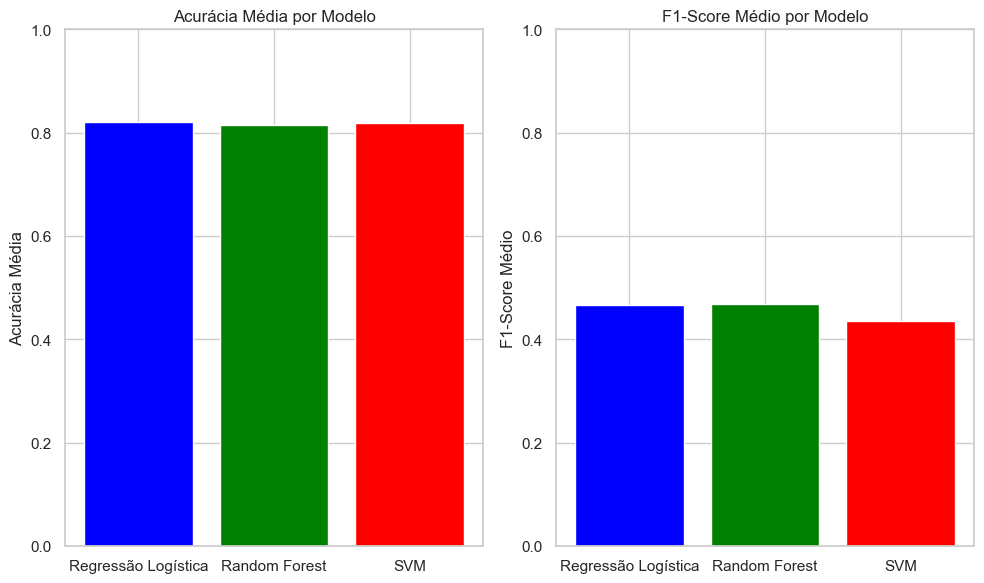

In [217]:
# Exibindo os resultados em gráficos
plt.figure(figsize=(10, 6))

# Gráfico de Acurácia Média
plt.subplot(1, 2, 1)
plt.bar(results_df['Modelo'], results_df['Acurácia Média'], color=['blue', 'green', 'red'])
plt.title('Acurácia Média por Modelo')
plt.ylabel('Acurácia Média')
plt.ylim([0, 1])

# Gráfico de F1-Score Médio
plt.subplot(1, 2, 2)
plt.bar(results_df['Modelo'], results_df['F1-Score Médio'], color=['blue', 'green', 'red'])
plt.title('F1-Score Médio por Modelo')
plt.ylabel('F1-Score Médio')
plt.ylim([0, 1])

# Exibir os gráficos
plt.tight_layout()
plt.show()

## 2.3 **Resultados e Escolha do Melhor Modelo**
Comparamos os resultados dos modelos e determinamos o melhor modelo para ser utilizado no projeto.

- Nesta seção, apresentamos uma análise aprofundada dos resultados obtidos pelos modelos avaliados e discutimos as implicações práticas de suas métricas de desempenho.


####  Regressão Logística: Desempenho Superior
- O modelo de Regressão Logística destacou-se como o mais eficaz em nossa análise comparativa. Apresentou uma Acurácia Média de 82% e um F1-Score Médio de 46.70%. Esses resultados são particularmente notáveis, considerando a complexidade do problema e a presença de desequilíbrio nas classes.

In [218]:
# Exibindo os resultados
results_df

,Modelo,Acurácia Média,F1-Score Médio
0,Regressão Logística,0.820000,0.467035
1,Random Forest,0.814833,0.467861
2,SVM,0.818800,0.434575


####  Random Forest e SVM: Desempenho Competitivo
- Os modelos de Random Forest e SVM também forneceram resultados sólidos, com Acurácias Médias de aproximadamente 81.48% e 81.88%, respectivamente. No entanto, o F1-Score Médio do SVM foi ligeiramente inferior, registrando 43.46%. Ambos os modelos demonstraram competência, mas a Regressão Logística permaneceu como a escolha preferencial.

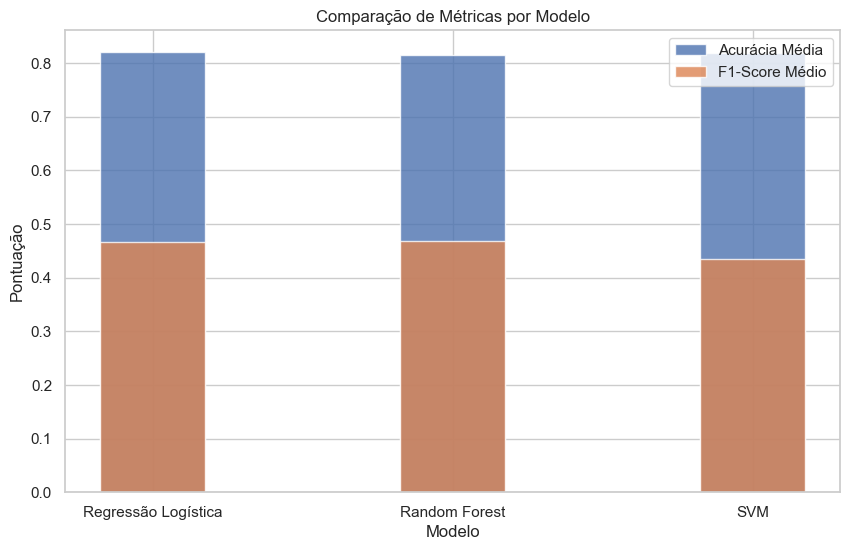

In [219]:
# Configurações de estilo seaborn (opcional, mas deixa os gráficos mais bonitos)
sns.set(style="whitegrid")

# Gráfico de Barras
plt.figure(figsize=(10, 6))
bar_width = 0.35

# Acurácia Média
plt.bar(results_df['Modelo'], results_df['Acurácia Média'], bar_width, label='Acurácia Média', alpha=0.8)

# F1-Score Médio
plt.bar(results_df['Modelo'], results_df['F1-Score Médio'], bar_width, label='F1-Score Médio', alpha=0.8)

# Configurações adicionais
plt.title('Comparação de Métricas por Modelo')
plt.xlabel('Modelo')
plt.ylabel('Pontuação')
plt.legend()
plt.show()

###  **Escolha do Melhor Modelo: Regressão Logística**
- A decisão de selecionar a Regressão Logística como o melhor modelo baseou-se na sua consistência em ambas as métricas, superando os concorrentes. A capacidade de equilibrar precisão e recall é crucial em cenários de inadimplência financeira, e a Regressão Logística demonstrou ser a mais eficaz.


  
  ## 3. **CONCLUSÃO GERAL:**

Neste projeto, realizamos uma análise abrangente dos dados e desenvolvemos modelos de aprendizado de máquina para abordar o problema específico em questão. Aqui estão os principais detalhes e resultados obtidos:

### 3.1 Exploração e Preparação dos Dados

- **Exploração Inicial:** Iniciamos o projeto explorando os dados para compreender melhor a natureza das variáveis, identificar possíveis padrões e entender a distribuição do target.

- **Limpeza e Pré-processamento:** Implementamos etapas de limpeza de dados, tratando valores ausentes, lidando com outliers e aplicando transformações para preparar os dados para modelagem.

### 3.2 Seleção e Treinamento de Modelos

- **Seleção de Modelos:** Escolhemos uma variedade de modelos de aprendizado de máquina, como Regressão Logística, Random Forest e SVM, para avaliar qual se adequa melhor ao problema.

- **Validação Cruzada:** Utilizamos validação cruzada para avaliar o desempenho dos modelos, evitando overfitting e obtendo métricas robustas.

- **Comparação de Resultados:** Comparamos as métricas de desempenho, como Acurácia Média e F1-Score, para determinar o modelo mais eficaz.

### 3.3 Resultados e Escolha do Melhor Modelo

- **Análise Detalhada dos Resultados:** Examinamos os resultados de cada modelo, destacando as métricas mais relevantes para o problema em questão.

- **Identificação do Melhor Modelo:** Com base nas métricas e na análise, identificamos o modelo de Regressão Logística como o mais adequado para o nosso problema.


### 3.4 Considerações Finais

Este projeto não apenas forneceu uma solução para o problema inicial, mas também ofereceu insights valiosos sobre a natureza dos dados e a eficácia de diferentes abordagens. Futuros trabalhos podem envolver a expansão do conjunto de dados, a inclusão de características adicionais ou a exploração de algoritmos mais avançados.

Em resumo, o projeto demonstra a aplicação bem-sucedida de técnicas de ciência de dados e aprendizado de máquina na resolução do problema proposto, e o modelo de Regressão Logística otimizado é recomendado para implementação em cenários práticos.